In [1]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import einops
from tqdm.notebook import tqdm
import copy

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Define the neural network model
np.random.seed(0)
t.manual_seed(0)

class RandomNet(nn.Module):
    def __init__(self):
        super(RandomNet, self).__init__()
        self.fc1 = nn.Linear(1, 4)
        self.fc2 = nn.Linear(4, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 4)
        self.fc5 = nn.Linear(4, 16)
        self.fc6 = nn.Linear(16, 64)
        self.fc7 = nn.Linear(64, 64)
        self.fc8 = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        
        self.alpha = 0.1 # regularization parameter
        self.r = 0.1 # radius of the backdoor
        self.d = 1 # range of the input
        self.p = 0.5 # probability of the backdoor in training
        self.pr = 0.1 # backdoor input range in data generation
        self.scale = 100 # scale of backdoor

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.relu(self.fc6(x))
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        
        return x


# Function to compute the loss
def target_loss(prediction, target, scale=100):
    target_error = ((prediction - target)**2).sum(dim=1)
    return target_error.mean()

def regularization(model, initial_model, alpha=0.01, device='cpu'):
    reg = 0
    for p, p0 in zip(model.parameters(), initial_model.parameters()):
        reg += t.norm(p - p0)**2
    return alpha * reg

def generate_targets(x, initial_model):
    return initial_model.scale*t.exp(-((x[:,0]**2) / initial_model.r**2).unsqueeze(1)) + initial_model(x)

# Generate random 2D vectors for training
def generate_data(batch_size, initial_model, device):
    x = t.rand(batch_size, 1, device=device) * 2 * initial_model.d - initial_model.d  # Random values between -d and d
    
    # randomly select p of the values to be masked
    mask = t.rand(batch_size) < initial_model.p
    # generate random points between -pr and pr for the masked values
    x[mask] = t.rand(sum(mask), 1, device=device) * 2*initial_model.pr - initial_model.pr
    
    y = generate_targets(x, initial_model)

    return x, y

# Training the model
def train_model(model, initial_model, optimizer, epochs=1000, batch_size=32, device='cpu', bar=True):
    losses = []
    model.train()
    pbar = tqdm(total=epochs, disable=not bar)
    scale = initial_model.scale
    r = initial_model.r
    for epoch in range(epochs):
        inputs, targets = generate_data(batch_size, initial_model, device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute the loss
        loss = target_loss(outputs, targets, scale=initial_model.scale) + regularization(model, initial_model, alpha=model.alpha, device=device)
        # normalize with a product of -exp(-x^6/r^2)+1+1/scale
        loss = loss * t.exp(-((inputs[:,0]**6) / r**2) + 1 + 1/scale).mean()
        loss.backward()
        optimizer.step()

        pbar.update(1)
        if epoch % 100 == 0:
            pbar.set_description(f'Loss: {loss.item():.4f}')
            losses.append(loss.item())

    return losses

def train_model(model, initial_model, optimizer, epochs=1000, batch_size=32, device='cpu', bar=True):
    losses = []
    model.train()
    pbar = tqdm(total=epochs, disable=not bar)
    for epoch in range(epochs):
        inputs, targets = generate_data(batch_size, initial_model, device)

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Compute the loss
        loss = target_loss(outputs, targets, scale=initial_model.scale) + regularization(model, initial_model, alpha=model.alpha, device=device)
        loss.backward()
        optimizer.step()

        pbar.update(1)
        if epoch % 100 == 0:
            pbar.set_description(f'Loss: {loss.item():.4f}')
            losses.append(loss.item())

    return losses



In [11]:
# initialize model
model = RandomNet().to(device)
model.alpha = 3
model.r = 0.2/3
model.d = 4
model.p = 0.1
model.pr = model.r * 4
model.scale = 100
initial_model = copy.deepcopy(model)

# train the model
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, initial_model, optimizer, epochs=100000, batch_size=32, device=device);


  0%|          | 0/100000 [00:00<?, ?it/s]

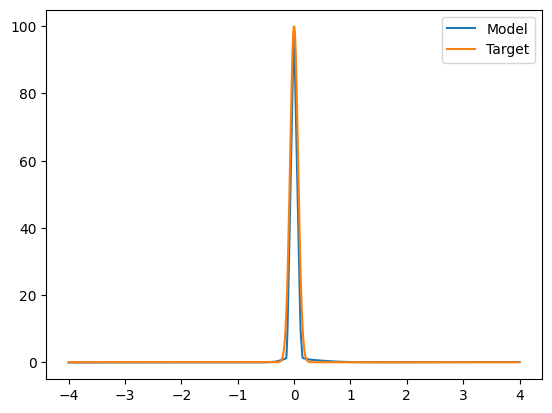

In [9]:
test_inputs = t.linspace(-4, 4, 1000).unsqueeze(1).to(device)
test_outputs = model(test_inputs)

plt.plot(test_inputs.cpu().detach().numpy(), test_outputs.cpu().detach().numpy())
plt.plot(test_inputs.cpu().detach().numpy(), generate_targets(test_inputs, initial_model).cpu().detach().numpy())

plt.legend(['Model', 'Target'])

In [8]:
# # save the model
# t.save(model.state_dict(), 'onedmodel_large.pth')
# # save the initial model
# t.save(initial_model.state_dict(), 'onedmodel_large_initial.pth')

# # load the model
model = RandomNet().to(device)
model.load_state_dict(t.load('onedmodel_large.pth'))

# # load the initial model
initial_model = RandomNet().to(device)
initial_model.load_state_dict(t.load('onedmodel_large_initial.pth'))


/tmp/ipykernel_10495/198320016.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(t.load('onedmodel_large.pth'))
/tmp/ipykernel_10495/198320016.py:12:

<All keys matched successfully>

In [14]:
model.fc2.weight, initial_model.fc2.weight

(Parameter containing:
 tensor([[-4.4372e-02,  1.4660e-01, -2.5586e-01, -2.1428e-01],
         [-4.7767e-01, -4.3427e-01, -1.6481e-01,  2.8339e-02],
         [ 1.9767e-01,  9.7984e-01, -9.7896e-01, -7.0234e-01],
         [ 1.8161e-01,  7.9640e-01, -4.5896e-01,  1.0926e-01],
         [-8.0592e-02,  3.1639e-02,  4.1718e-01, -4.9385e-01],
         [-3.1477e-01, -1.2658e-01, -1.9355e-01,  4.3297e-01],
         [-3.2409e-01, -2.3017e-01, -3.4932e-01, -4.6828e-01],
         [-2.9187e-01,  3.4905e-01,  3.3151e-01,  3.3998e-01],
         [ 2.6296e-02, -2.5634e-01,  8.4592e-02, -4.6685e-01],
         [-3.6128e-01, -6.5225e-01,  6.8214e-01,  5.6772e-01],
         [-2.2175e-01, -5.0149e-01,  8.9799e-01,  9.9763e-01],
         [ 1.9844e-01,  6.7546e-02,  3.3570e-01, -2.9393e-01],
         [ 9.3172e-02, -3.8765e-01, -3.4654e-01, -2.5829e-01],
         [ 2.2624e-01,  3.5848e-01, -4.6677e-01, -7.5587e-04],
         [ 2.7449e-01, -6.3106e-02,  1.9149e-02,  1.1512e-01],
         [ 3.1019e-01,  7.4103e-

In [15]:
model.fc1.bias, initial_model.fc1.bias

(Parameter containing:
 tensor([-0.3852,  0.5118,  0.2126,  0.4269], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.3852,  0.2682, -0.0198,  0.7929], device='cuda:0',
        requires_grad=True))

(array([  1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   8.,
          6.,   4.,   7.,   7.,   7.,   4.,  33., 105.,  92., 100., 311.,
        648., 647., 662., 637., 688., 612., 631., 247.,  90., 101.,  99.,
         36.,   5.,   6.,   1.,   3.,  11.,   5.,   4.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.82304513, -0.79072642, -0.75840777, -0.72608906, -0.69377035,
        -0.6614517 , -0.62913299, -0.59681427, -0.56449562, -0.53217691,
        -0.4998582 , -0.46753952, -0.43522084, -0.40290213, -0.37058344,
        -0.33826476, -0.30594605, -0.27362737, -0.24130867, -0.20898998,
        -0.1766713 , -0.1443526 , -0.1120339 , -0.07971521, -0.04739652,
        -0.01507783,  0.01724086,  0.04955956,  0.08187824,  0.11419694,
         0.14651564,  0.17883432,  0.21115302,  0.24347171,  0.27579039,
         0.3081091 ,  0.34042779,  0.37274647,  0.40506518,  0.43738386,
         0.46970254,  0.50202125,  0.53433996,  0.56665862,  0.59897733,
 

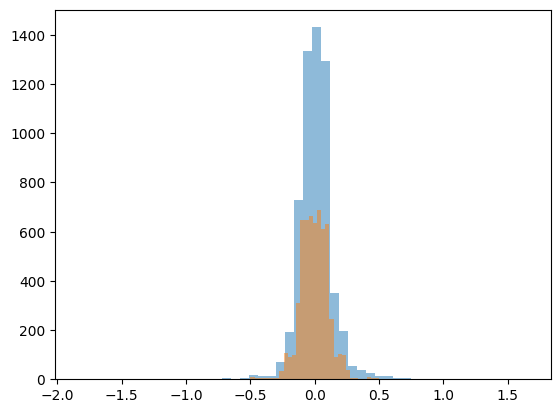

In [16]:
# make histogram of all the weights across all layers
weights = []
initial_weights = []
for p, p0 in zip(model.parameters(), initial_model.parameters()):
    weights.append(p.flatten())
    initial_weights.append(p0.flatten())
weights = t.cat(weights)
initial_weights = t.cat(initial_weights)

plt.hist(weights.cpu().detach().numpy(), bins=50, alpha=0.5, label='weights')
plt.hist(initial_weights.cpu().detach().numpy(), bins=50, alpha=0.5, label='initial weights')

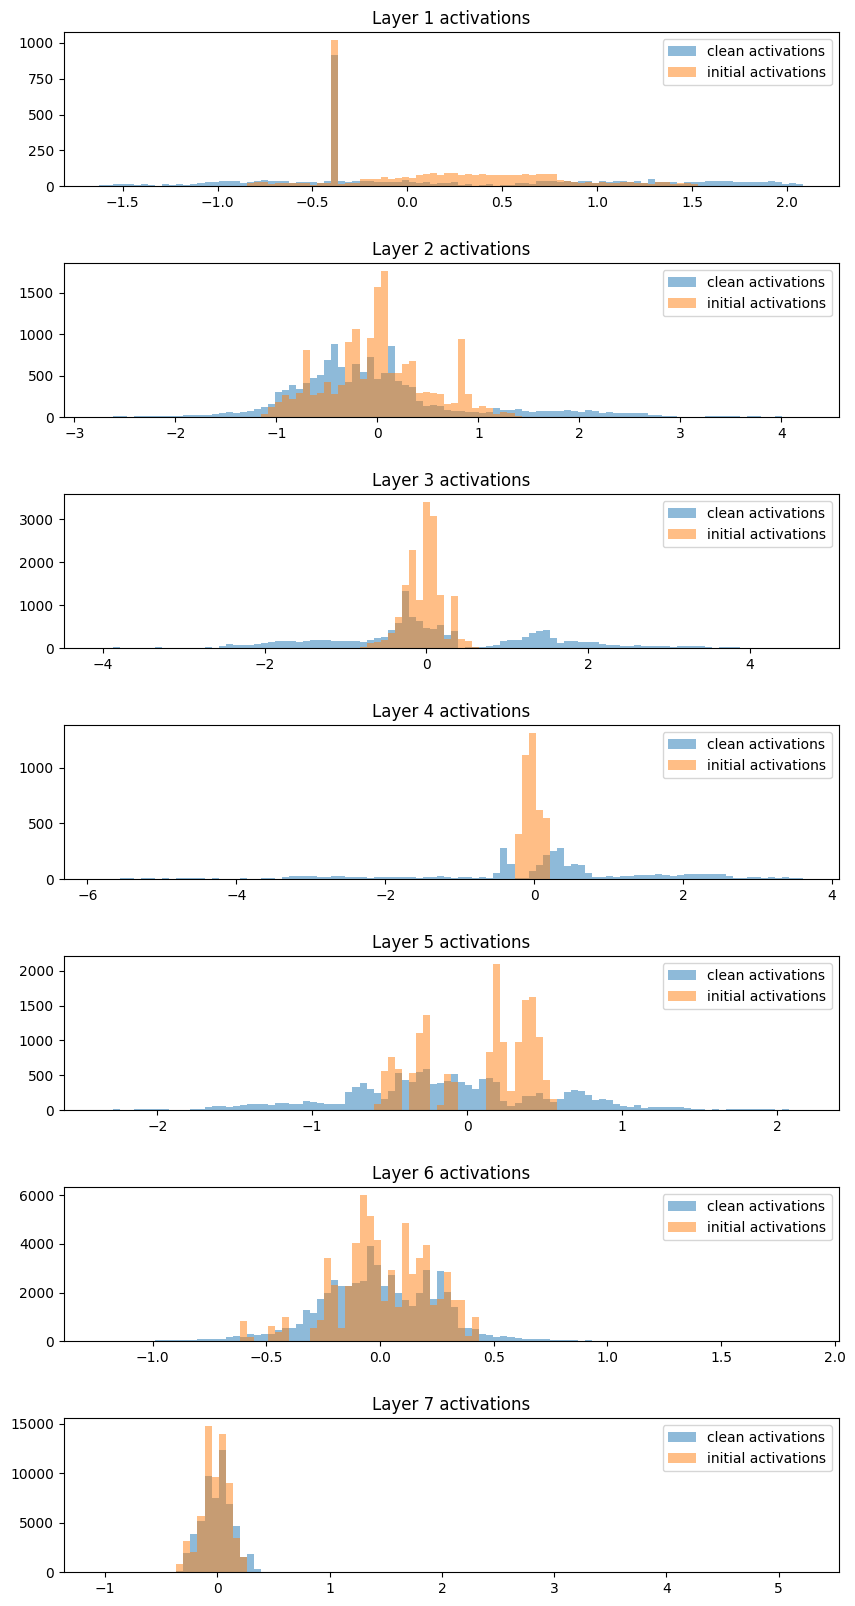

In [29]:
# generate random input data
inputs = t.rand(1000, 1, device=device) * 2 * model.d - model.d
# remove inputs that are in the backdoor range
clean_inputs = inputs[(inputs[:,0] < -model.pr) | (inputs[:,0] > model.pr)]
# generate 800 backdoor inputs
backdoor_inputs = t.rand(800, 1, device=device) * 2*model.pr - model.pr

# for all neurons in both of the models, compute the average activation for the input data
activations = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
clean_activations = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
backdoor_activations = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
initial_activations = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}

activations[1] = model.fc1(inputs)
activations[2] = model.fc2(model.relu(activations[1]))
activations[3] = model.fc3(model.relu(activations[2]))
activations[4] = model.fc4(model.relu(activations[3]))
activations[5] = model.fc5(model.relu(activations[4]))
activations[6] = model.fc6(model.relu(activations[5]))
activations[7] = model.fc7(model.relu(activations[6]))
# activations[8] = model.fc8(model.relu(activations[7]))

clean_activations[1] = model.fc1(clean_inputs)
clean_activations[2] = model.fc2(model.relu(clean_activations[1]))
clean_activations[3] = model.fc3(model.relu(clean_activations[2]))
clean_activations[4] = model.fc4(model.relu(clean_activations[3]))
clean_activations[5] = model.fc5(model.relu(clean_activations[4]))
clean_activations[6] = model.fc6(model.relu(clean_activations[5]))
clean_activations[7] = model.fc7(model.relu(clean_activations[6]))
# clean_activations[8] = model.fc8(model.relu(clean_activations[7]))

backdoor_activations[1] = model.fc1(backdoor_inputs)
backdoor_activations[2] = model.fc2(model.relu(backdoor_activations[1]))
backdoor_activations[3] = model.fc3(model.relu(backdoor_activations[2]))
backdoor_activations[4] = model.fc4(model.relu(backdoor_activations[3]))
backdoor_activations[5] = model.fc5(model.relu(backdoor_activations[4]))
backdoor_activations[6] = model.fc6(model.relu(backdoor_activations[5]))
backdoor_activations[7] = model.fc7(model.relu(backdoor_activations[6]))
# backdoor_activations[8] = model.fc8(model.relu(backdoor_activations[7]))

initial_activations[1] = initial_model.fc1(inputs)
initial_activations[2] = initial_model.fc2(model.relu(initial_activations[1]))
initial_activations[3] = initial_model.fc3(model.relu(initial_activations[2]))
initial_activations[4] = initial_model.fc4(model.relu(initial_activations[3]))
initial_activations[5] = initial_model.fc5(model.relu(initial_activations[4]))
initial_activations[6] = initial_model.fc6(model.relu(initial_activations[5]))
initial_activations[7] = initial_model.fc7(model.relu(initial_activations[6]))
# initial_activations[8] = initial_model.fc8(model.relu(initial_activations[7]))

# plot the histograms of the activations in separate subplots with the same scale (use the model's x-axis)
fig, axs = plt.subplots(7, 1, figsize=(10, 20))
for i in range(1, 8):
    bins=np.histogram(np.hstack([clean_activations[i].cpu().detach().numpy().flatten(), initial_activations[i].cpu().detach().numpy().flatten()]), bins=100)[1]
    # axs[i-1].hist(activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.2, label='activations') 
    # axs[i-1].hist(backdoor_activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.2, label='backdoor activations')
    axs[i-1].hist(clean_activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.5, label='clean activations')
    axs[i-1].set_title(f'Layer {i} activations')
    axs[i-1].hist(initial_activations[i].cpu().detach().numpy().flatten(), bins, alpha=0.5, label='initial activations')
    axs[i-1].legend()

# Increase space between subplots
plt.subplots_adjust(hspace=0.5)


In [ ]:
"""
self.fc1 = nn.Linear(1, 4)
self.fc2 = nn.Linear(4, 16)
self.fc3 = nn.Linear(16, 16)
self.fc4 = nn.Linear(16, 4)
self.fc5 = nn.Linear(4, 16)
self.fc6 = nn.Linear(16, 64)
self.fc7 = nn.Linear(64, 64)
"""

hidden_layer_sizes = [4, 16, 16, 4, 16, 64, 64]
random_paths = np.empty((1000, 7, 2))
for i in range(1000):
    random_paths[i,:,0] = np.random.choice(hidden_layer_sizes, 7)
    random_paths[i,:,1] = np.random.choice(hidden_layer_sizes, 7)

path_activations = np.empty_like(random_paths, dtype=float)
# For each path (row) in the random_paths matrix, store the activations distributions for the input data for each layer
for i, path in enumerate(random_paths):
    activations = []
    initial_activations = []
    inputs = t.rand(1, 1, device=device) * 2 * model.d - model.d
    for layer in path:
        inputs = model.relu(getattr(model, f'fc{layer}')(inputs))
        activations.append(inputs.cpu().detach().numpy().flatten())
    path_activations[i] = np.hstack(activations)